In [ ]:
log_path = 'fixed_value/2025-10-21'
import numpy as np
import re
import os
from omegaconf import OmegaConf
from flp2p.utils import compute_weight_matrix
import networkx as nx
import pickle

def get_metrics(data):
    overall_distance_p = re.compile(r'Overall consensus distance : ([\d\.]+)')
    inter_cluster_distance_p = re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_1_distance_p =  re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_2_distance_p =  re.compile(r'Cluster 2 consensus distance : ([\d\.]+)')
    
    overall_distance, inter_cluster_distance, cluster_1_distance, cluster_2_distance = [], [], [], []
    for match in overall_distance_p.finditer(data):
        overall_distance.append(float(match.group(1)))
        
    for match in inter_cluster_distance_p.finditer(data):
        inter_cluster_distance.append(float(match.group(1)))
    
    for match in cluster_1_distance_p.finditer(data):
        cluster_1_distance.append(float(match.group(1)))
           
    for match in cluster_2_distance_p.finditer(data):
        cluster_2_distance.append(float(match.group(1)))

    return {"overall_distance": overall_distance,
            "inter_cluster_distance": inter_cluster_distance,
            "cluster_1_distance": cluster_1_distance,
            "cluster_2_distance": cluster_2_distance}

res = {}
for log_dir in os.listdir(log_path):
    log_file  = f'{log_path}/{log_dir}'
    if os.path.isfile(log_file):
        continue
    with open(f'{log_file}/fixed_value_training.log', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)
    W = compute_weight_matrix(graph, config_file.mixing_matrix)
    algebric_value = nx.algebraic_connectivity(graph)
    res_dict = get_metrics(data)
    res[f'{log_dir.split('/')[-1]}_{config_file.mixing_matrix}'] = res_dict
    res[f'{log_dir.split('/')[-1]}_{config_file.mixing_matrix}']['algebric_connectivity'] = algebric_value


In [26]:
print(list(res.keys()))
print(list(res[list(res.keys())[0]].keys()))

['13-59-07_matcha', '13-48-38_metropolis_hasting', '13-58-49_maximum_degree']
['overall_distance', 'inter_cluster_distance', 'cluster_1_distance', 'cluster_2_distance']


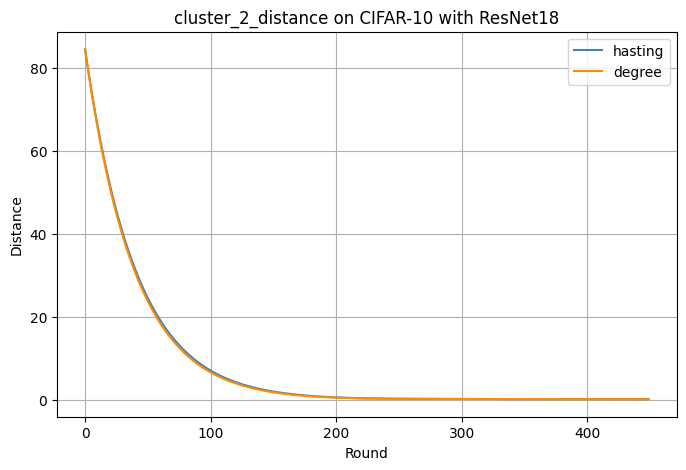

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(res.keys())
epochs = np.arange(max(map(lambda x: len(res[x]['overall_distance']), res)))
plt.figure(figsize=(8, 5))

# plt.plot(epochs, np.convolve(np.array(res[comparaison[0]][4]), np.ones(10)/10)[:200], label="without gradients", color="red")
# plt.plot(epochs,  np.convolve(np.array(res[comparaison[1]][4]), np.ones(10)/10)[:200], label="with gradients", color="orange")#
mh_key = '13-48-38_metropolis_hasting'
maximum_degree_key = '13-58-49_maximum_degree'
index_elem = 'cluster_2_distance'
epochs = 450
plt.plot(np.arange(epochs), res[mh_key][index_elem][:epochs], color="steelblue", marker='', label=f'{mh_key.split('_')[-1]}')
#plt.fill_between(epochs, np.array(res[mh_key][3])[:epochs] - np.array(res[mh_key][std_elem])[:epochs], np.array(res[mh_key][3])[:epochs] + np.array(res[mh_key][std_elem])[:epochs], 
#              color='steelblue', alpha=0.2)

plt.plot(np.arange(epochs), res[maximum_degree_key][index_elem][:epochs], color="darkorange", marker='', label=f'{maximum_degree_key.split('_')[-1]}')
#plt.fill_between(epochs np.array(res[matcha_key][3])[:epochs] - np.array(res[matcha_key][std_elem])[:epochs], np.array(res[matcha_key][3])[:epochs] + np.array(res[matcha_key][std_elem]):epochs[], 
#                 color='darkorange', alpha=0.2)
#plt.plot(epochs, res[keys[3]][3], color="red", marker='_', label='no memory')
# plt.plot(epochs[:len(res[keys[1]][3])], res[keys[1]][3], color="red", marker='x', label=trali'metropolis')
# plt.plot(epochs[:len(res[keys[2]][3])], res[keys[2]][3],color="green", marker='_', label='proba')
# plt.plot(epochs[:len(res[keys[3]][3])], res[keys[3]][3], color="green", marker='x', label='proba')
#plt.ylim((0.2, 1))
plt.xlabel("Round")
plt.ylabel("Distance")
plt.title(f"{index_elem} on CIFAR-10 with ResNet18")
#plt.legend(handles=[dirichlet, pathological, iid])
plt.legend()
plt.grid(True)
plt.show()